<a href="https://colab.research.google.com/github/BehnamLatifi/Sample-Project/blob/main/Deep_Learning_with_PyTorch_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GradCAM - Gradient Class Activation Map

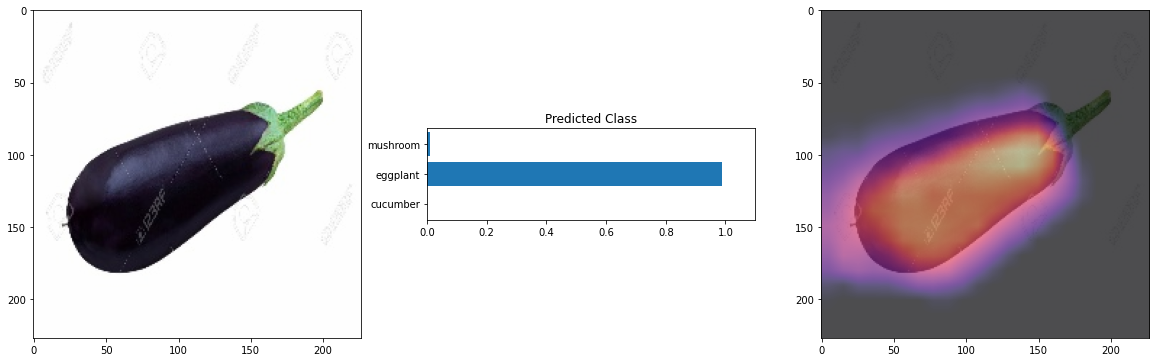

In [ ]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# Imports

In [ ]:
import sys
sys.path.append('/content/GradCAM-Dataset')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [ ]:
DATA_DIR = '/content/GradCAM-Dataset/'
CSV_FILE = '/content/GradCAM-Dataset/train.csv'

BATCH_SIZE = 16
LR = 0.001
EPOCHS = 20

DEVICE = 'cuda'

In [ ]:
data = pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [ ]:
train_df, valid_df = train_test_split(data, test_size = 0.2, random_state = 42)

# Augmentations

In [ ]:
train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

valid_augs = A.Compose([
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Load Image Dataset

In [ ]:
trainset = utils.ImageDataset(train_df, augs = train_augs, data_dir = DATA_DIR)
validset = utils.ImageDataset(valid_df, augs = valid_augs, data_dir = DATA_DIR)

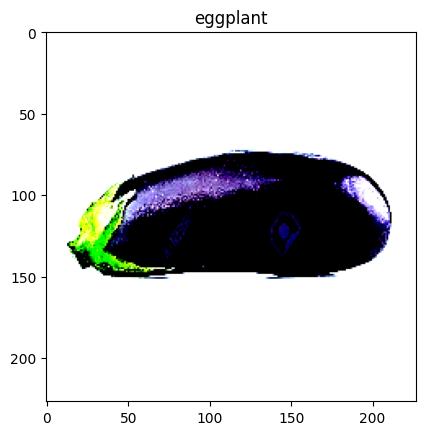

In [ ]:
image, label = trainset[0] #(c, h, w) -> (h, w, c)
class_list = ['cucumber', 'eggplant', 'mushroom']
plt.imshow(image.permute(1, 2, 0))
plt.title(class_list[label]);

In [ ]:
print(f"No. of examples in the {len(trainset)}")
print(f"No. of examples in the {len(validset)}")

No. of examples in the 148
No. of examples in the 38


# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [ ]:
for images, labels in trainloader:
  break;

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


# Create Model

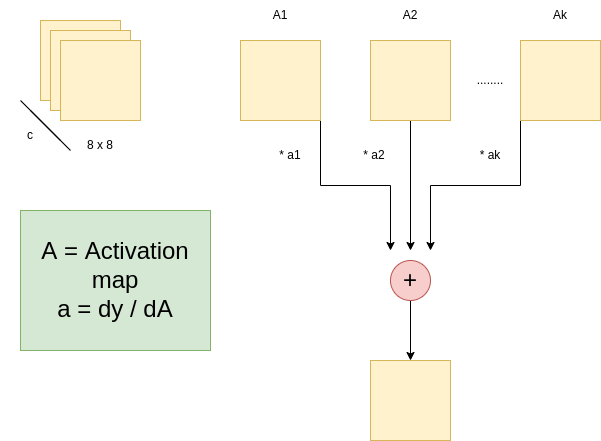

In [ ]:
from torch.nn import Conv2d, ReLU, Flatten, MaxPool2d, Linear
class ImageModel(nn.Module):
  def __init__(self):
    super(ImageModel, self).__init__()
    self.feature_extractor = nn.Sequential(
        Conv2d(in_channels = 3, out_channels = 16, kernel_size = (5, 5), padding = 1),
        ReLU(),
        MaxPool2d(kernel_size = (4, 4), stride = 2),

        Conv2d(in_channels = 16, out_channels = 16, kernel_size = (5, 5), padding = 1),
        ReLU(),
        MaxPool2d(kernel_size = (4, 4), stride = 2),

        Conv2d(in_channels = 16, out_channels = 32, kernel_size = (5, 5), padding = 1),
        ReLU(),
        MaxPool2d(kernel_size = (4, 4), stride = 2),

        Conv2d(in_channels = 32, out_channels = 64, kernel_size = (5, 5), padding = 1),
        ReLU()
    )
    self.maxpool = MaxPool2d(kernel_size = (4, 4), stride = 2)
    self.classifier = nn.Sequential(
        Flatten(),
        Linear(6400, 2048),
        ReLU(),
        Linear(2048, 3)
    )
    self.gradient = None

  def activations_hook(self, grad):
    self.gradient = grad

  def forward(self, images):
    x = self.feature_extractor(images)
    h = x.register_hook(self.activations_hook)
    x = self.maxpool(x)
    x = self.classifier(x)
    return x

  def get_activation_gradients(self):
    return self.gradient

  def get_activation(self, x):
    return self.feature_extractor(x)

In [ ]:
model = ImageModel()
model.to(DEVICE)

# Create Train and Eval function

In [ ]:
def train_fn(dataloader, model, optimizer, criterion):
  model.train()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    logits = model(images)
    loss= criterion(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(dataloader)

In [ ]:
def eval_fn(dataloader, model, criterion):
  model.eval()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    logits = model(images)
    loss= criterion(logits, labels)

    total_loss += loss.item()
  return total_loss / len(dataloader)

# Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr =LR)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer, criterion)
  valid_loss = eval_fn(validloader, model, criterion)
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_weights.pt')
    best_valid_loss = valid_loss
    print('SAVED_WEIGHTS_SUCCESS')
  print(f'EPOCH :{i + 1} TRAIN LOSS : {train_loss} VALID LOSS : {valid_loss}')

100%|██████████| 3/3 [00:00<00:00, 35.23it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH :1 TRAIN LOSS : 1.4317660331726074 VALID LOSS : 1.1917572816212971


100%|██████████| 3/3 [00:00<00:00, 32.99it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH :2 TRAIN LOSS : 1.0907022476196289 VALID LOSS : 1.095908761024475


100%|██████████| 3/3 [00:00<00:00, 34.25it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH :3 TRAIN LOSS : 1.0111648201942445 VALID LOSS : 0.9360958536465963


100%|██████████| 3/3 [00:00<00:00, 35.21it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH :4 TRAIN LOSS : 0.8329891264438629 VALID LOSS : 0.6988633672396342


100%|██████████| 3/3 [00:00<00:00, 23.30it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH :5 TRAIN LOSS : 0.6623101711273194 VALID LOSS : 0.5346898933251699


100%|██████████| 3/3 [00:00<00:00, 22.32it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH :6 TRAIN LOSS : 0.4262966737151146 VALID LOSS : 0.297497237722079


100%|██████████| 3/3 [00:00<00:00, 22.70it/s]


EPOCH :7 TRAIN LOSS : 0.5087543962639757 VALID LOSS : 0.495704506834348


100%|██████████| 3/3 [00:00<00:00, 34.29it/s]


EPOCH :8 TRAIN LOSS : 0.40797667354345324 VALID LOSS : 0.37479036549727124


100%|██████████| 3/3 [00:00<00:00, 34.77it/s]


EPOCH :9 TRAIN LOSS : 0.2703597530722618 VALID LOSS : 0.3303827146689097


100%|██████████| 3/3 [00:00<00:00, 34.56it/s]


EPOCH :10 TRAIN LOSS : 0.20851180087774993 VALID LOSS : 0.6566888925929865


100%|██████████| 3/3 [00:00<00:00, 34.34it/s]


EPOCH :11 TRAIN LOSS : 0.23393257707357407 VALID LOSS : 0.3278960933287938


100%|██████████| 3/3 [00:00<00:00, 33.87it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH :12 TRAIN LOSS : 0.3171134784817696 VALID LOSS : 0.10377487167716026


100%|██████████| 3/3 [00:00<00:00, 34.74it/s]


EPOCH :13 TRAIN LOSS : 0.1724337674677372 VALID LOSS : 0.30500090929369134


100%|██████████| 3/3 [00:00<00:00, 32.45it/s]


EPOCH :14 TRAIN LOSS : 0.24439294077455997 VALID LOSS : 0.28134433428446454


100%|██████████| 3/3 [00:00<00:00, 34.74it/s]


EPOCH :15 TRAIN LOSS : 0.1943111889064312 VALID LOSS : 0.49943752959370613


100%|██████████| 3/3 [00:00<00:00, 34.87it/s]


EPOCH :16 TRAIN LOSS : 0.21070319979917257 VALID LOSS : 0.6854182183742523


100%|██████████| 3/3 [00:00<00:00, 34.13it/s]


EPOCH :17 TRAIN LOSS : 0.18456339868716895 VALID LOSS : 0.10955815576016903


100%|██████████| 3/3 [00:00<00:00, 33.73it/s]


EPOCH :18 TRAIN LOSS : 0.06470340969972313 VALID LOSS : 0.5870276329418024


100%|██████████| 3/3 [00:00<00:00, 35.09it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH :19 TRAIN LOSS : 0.10917547666467727 VALID LOSS : 0.03318683461596569


100%|██████████| 3/3 [00:00<00:00, 35.13it/s]

EPOCH :20 TRAIN LOSS : 0.07927137571386993 VALID LOSS : 0.2578489786634843


# Get GradCAM

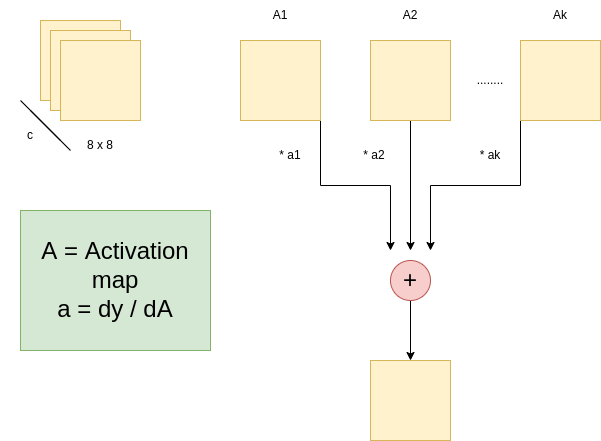

In [ ]:
def get_gradcam(model, image, label, size):
  label.backward()
  gradients = model.get_activation_gradients()
  pooled_gradients = torch.mean(gradients, dim = [0, 2, 3])
  activations = model.get_activation(image).detach()
  for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]
  heatmap = torch.mean(activations, dim = 1).squeeze().cpu()
  heatmap = ReLU()(heatmap)
  heatmap /= torch.max(heatmap)
  heatmap = cv2.resize(heatmap.numpy(), (size, size))
  return heatmap

In [ ]:
# cucumber - 0, eggplant - 1, mushroom - 2

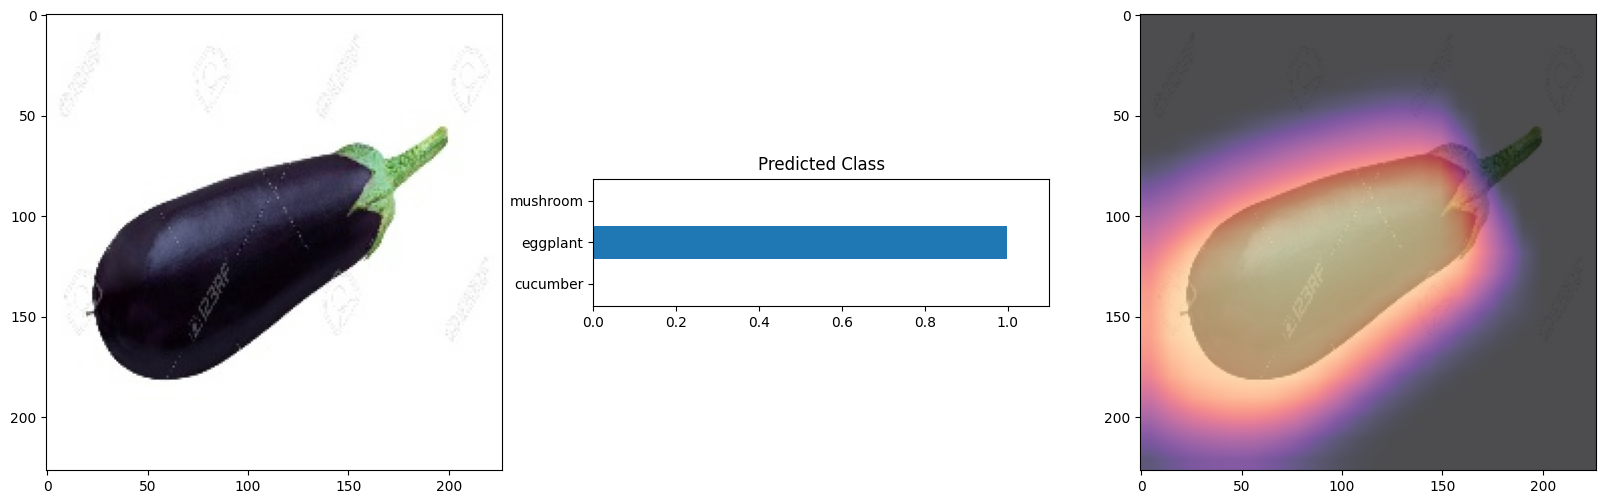

In [ ]:
image, label = validset[4]
denorm_image = image.permute(1, 2, 0) * np.array((0.229, 0.225, 0.225)) + np.array((0.485, 0.456, 0.406))
image = image.unsqueeze(0).to(DEVICE)
pred = model(image)
heatmap = get_gradcam(model, image, pred[0][1], size = 227)
utils.plot_heatmap(denorm_image, pred, heatmap)